# Create Experimental Data Set

I'd like to create experimental data set based on home characteristics and sales, where the theoretical model would be trying to predict eventual sale price.

I'll have:
- a continuous variable (square feet of living space)
- a categorical variable with a large number of categories (zip code, 50)
- a categorical variable with a small number of variables (condition, 5)
- a variable I'll create to add some randomness to the price, probably a "day of the week" where we'll pretend that the day of the week when the house was listed affects its price.

I'll be able to remove one each of the OHE categorical variables and model with all variables and get a very good model.

I can also not include the "day of the week" random variable to more closely approximate trying to model without data that explains all the variation.

To start with, square feet will have a normal distribution.

Zip codes will be created in random unequal sizes, but will be assigned a price multiplier based on a normal distribution. I'll make sure that the first zip code alpha-numerically is one with a smaller than average number of houses and larger than average or smaller than average price multipliers, so I can simulate dropping an outlier versus an average category.

The condition category will be poor, below average, average, above average, and excellent. It will be assigned randomly, and will be roughly normal but we will have mostly averages, a few below averages, and more above and excellent than below.




In [610]:
import numpy as np
np.set_printoptions(precision=3, suppress=True)

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from scipy import stats

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [589]:
def assign_cats(df_groups, df_records, ratio_map={}, seed=5):
    """Assigns group labels and multipliers to records to create an
    experimental data set.
    
    Returns the original mergeto dataframe with the group labels and 
    multipliers assigned in new columns.
    
    Keyword arguments:
    
    df_groups: a dataframe consisting of a group of categorical labels
    and corresponding multiplier column representing the weight of effect for
    that group. Group label should be in column 1 (index 0), and multiplier in 
    column 2 (index 1).
    
    df_records: a dataframe representing records to which the groups will be
    assigned. Records df should have more rows than groups, where groups will
    be assigned to batches of records.
    
    ratio_map: default, none. A dict consisting of keys = labels and 
    values = proportion of records to be assigned that label. Proportions
    should sum to 1. 
    
    - If a ratio map is passed, this will be used to determine
    group sizes instead of making them roughly equal and assigning to labels
    randomly.
    
    - If no ratio map passed, determines roughly even but varied group sizes 
    based on number of groups and number of total records, and assigns the 
    group labels and multipliers to the records randomly.
    
    seed: default 5. Integer representing random seed for reproducability.
    """
    np.random.seed(seed)
    
    record_ct = len(df_records)
    group_ct = len(df_groups)
    groups_sizes = []
    group_index = []
    
    # apply group sizes using ratio map, if passed
    if len(ratio_map.items()) > 0:
        
        for i, v in enumerate(ratio_map.values()):
            if i == (group_ct - 1):
                remaining = record_ct - np.sum(groups_sizes)
                groups_sizes.append(np.around(remaining, decimals=0))
            else:
                groups_sizes.append(np.around((record_ct * v), decimals=0))
        
    else:
        # determine the group size if we were to divide evenly
        split = np.around((record_ct / group_ct), decimals=0)

        # loop for each group and assign it a randomly altered size
        while len(groups_sizes) < group_ct:

            # if last 4 groups, spread evenly between them
            if len(groups_sizes) == (group_ct - 4):
                remaining = record_ct - np.sum(groups_sizes)
                last4 = np.around((remaining / 4), decimals=0)
                for i in range(0, 3):
                    groups_sizes.append(last4)
                groups_sizes.append(record_ct - np.sum(groups_sizes))
            else:
                # generate a random int between size and 0 to alter the size
                alterby = np.random.randint(low=0, high=split, dtype=int)

                # add alter variable to half the size and append to list
                groups_sizes.append((np.around((split / 2), decimals=0)) + alterby)
    
    # loop through groups and create appropriate number of copies for
    # each group size
    for i, size in enumerate(groups_sizes):
        for j in range(0, int(size)):
            group_index.append(list(df_groups.iloc[i].values))
            
    # shuffle group index to re-randomize it
    np.random.shuffle(group_index)
    
    group_records = pd.DataFrame(group_index, columns=df_groups.columns)
    
    # concatenate dfs
    new_df = pd.concat([df_records, group_records], axis=1)

    return new_df

In [590]:
def explore_data(to_explore, df, target, hist=True, box=True, plot_v_target=True,
                 summarize=True, norm_check=True):
    """Creates plots and summary information intended to be useful in preparing
    for linear regerssion modeling. Prints plots of distributions, a scatter
    plot of each predictor column against a target, and outputs a dataframe of
    metadata including results of a normality check and correlation coefficient.
    
    Keyword arguments:
    
    to_explore: list of column names to explore
    
    df: Dataframe containing the columns in to_explore, as well as the target
        column
    
    target: string of the column name to use as the target, or dependent variable
    
    hist: True or False (default True). Whether to include a histogram for each
    predictor column.
    
    box: True or False (default True). Whether to include a box plot for each
    predictor column.
    
    plot_v_target: True or False (default True). Whether to include a scatter 
    plot showing the predictor versus target
    
    summarize: True or False (default True). Whether to include a summary of
    the values in each predictor column. Data will be summarized using 
    df.describe() for variables deemed continuous, and df.sort_values()
    for variables deemed categorical. Classification of continuous versus
    categorical is best effort.
    
    norm_check: True or False (default True). Whether to perform a normality
    check using SciPy's stats omnibus normality test. Null hypothesis 
    is that the data comes from a normal distribution, so a value less than
    0.05 represents likely NOT normal data.
    """
    
    # Create some variables to dynamically handle including/excluding 
    # certain charts
    num_charts = 0
    if hist:
        num_charts += 1
    if box:
        num_charts += 1 
    if plot_v_target:
        num_charts += 1
        
    # check if input column is a list; if not, make it one. This allows for
    # a string to be passed if only one column is being summarized.
    if type(to_explore) == str:
        temp_list = [to_explore]
        to_explore = temp_list
    
    # column headers for metadata output df
    meta_list = [['col_name', 'corr_target', 'assumed_var_type', 'omnibus_k2',
                 'omnibus_pstat', 'is_normal', 'uniques', 'mean', 'median']]
    
    # loop through each column in the list to analyze
    for col in to_explore:
        
        header_line = '-'*75
        header_text = f'\nSummary of Data for column: {col}\n'
        print(header_line + header_text + header_line)
        
        # Determine if categorical or continuous
        # assume continuous to begin with
        var_type = 'continuous'
        data_type = df[col].dtype
        uniques = np.nan
        mean = np.nan
        median = np.nan
        num_uniques = len(df[col].unique())
        
        if df[col].dtype in ['int64', 'float64']:
            # number types need the most analysis because they could be
            # categorical even if they're numeric
            
            # using 100 as an arbitrary cutoff here, may need adjustment
            if num_uniques < 20:
                var_type = 'categorical'
                uniques = num_uniques
            else:
                mean = np.mean(df[col])
                median = np.median(df[col])
        elif df[col].dtype in ['object']:
            # Assuming column types have been fixed at this point,
            # so if a column is not numerical it must be categorical
            var_type = 'categorical'
            uniques = num_uniques
        elif df[col].dtype in ['datetime64']:
            var_type = 'date'
            
        # print summary based on data type
        if summarize:
            if var_type in ['continuous', 'date']:
                print(df[col].describe())
            else:
                with pd.option_context('display.max_rows', 20):
                    print(df[col].value_counts())
        
        # creates scatter plots, histogram, and box plots for numerical data
        if data_type in ['int64', 'float64']:
            if num_charts > 0:

                fig, axes = plt.subplots(nrows=num_charts, ncols=1, 
                                         figsize=(8, num_charts * 5))
                if hist:
                    if num_charts > 1:
                        ax1 = axes[0]
                    else:
                        ax1 = axes

                    if box:
                        ax2 = axes[1]
                        if plot_v_target:
                            ax3 = axes[2]
                    elif plot_v_target:
                        ax3 = axes[1]
                elif box:
                    if num_charts > 1:
                        ax2 = axes[0]
                    else:
                        ax2 = axes

                    if plot_v_target:
                        ax3 = axes[1]

                elif plot_v_target:
                    ax3 = axes


                # add a little extra space for headers
                plt.subplots_adjust(hspace=0.3)

                # Histogram
                if hist:
                    sns.histplot(df[col], kde=True, ax=ax1)
                    ax1.set_title(f"Hist {col}")

                # Box plot
                if box:
                    sns.boxplot(x=df[col], ax=ax2)
                    ax2.set_title(f"Boxplot {col}")

                # Plot against target
                # create a series representing quartiles, to use as hue
                if plot_v_target:                
                    if var_type == 'continuous':
                        try:
                            quartile_labels=['q1', 'q2', 'q3', 'q4']
                            quartiles = pd.qcut(df[col], 4, 
                                                labels=quartile_labels, 
                                                duplicates='drop')
                            sns.scatterplot(x=df[col], y=df[target], ax=ax3, 
                                            hue=quartiles)
                            ax3.legend(title=f'{col} quartiles')
                            
                        except:
                            sns.scatterplot(x=df[col], y=df[target], ax=ax3)
                    else:
                        sns.scatterplot(x=df[col], y=df[target], ax=ax3)
                    ax3.set_title(f"{col} versus {target}")
                    
                plt.show();
                
            # get pearson correlation coefficient between col and target
            corr = df[[col, target]].corr()

            # Test for normality using scipy omnibus normality test
            # null hypothesis is that the data comes from a normal distribution
            if norm_check:
                k2, p = stats.normaltest(df[col])
                if p < 0.05:
                    normal = False
                    print(f'\nData is NOT normal with p-statistic = {p}\n')
                else:
                    normal = True
                    print(f'\nData IS normal with p-statistic = {p}\n')

            # append metadata to list of lists
            meta_list.append([col, corr.iloc[0][1], var_type, k2, p, normal, 
                uniques, mean, median])
            
        # Create catplot for categorical data
        elif data_type in ['object', 'str']:
            
            h = len(df[col].value_counts())
            fig, ax = plt.subplots(figsize=(8, (h*0.15)+4))
            sns.barplot(x=target, y=col, data=df, orient='h', ax=ax)
            ax.set_title(f"Average {target} per {col}");
            plt.show();
        
    df_meta = pd.DataFrame(data=meta_list[1:], columns=meta_list[0])
    return df_meta

## Sq Ft

In [591]:
# Generate sq ft

# Set random seed for reproducability
np.random.seed(5)
df = pd.DataFrame(((np.random.randn(20000)) + 4) * 700, columns=['sqft'])

print(df.head())
print(f"Mean sq ft: {np.mean(df)}")
print(f"Median sq ft: {np.median(df)}")

          sqft
0  3108.859241
1  2568.390894
2  4501.539831
3  2623.535509
4  2876.726889
Mean sq ft: sqft    2801.13057
dtype: float64
Median sq ft: 2803.5581213839223


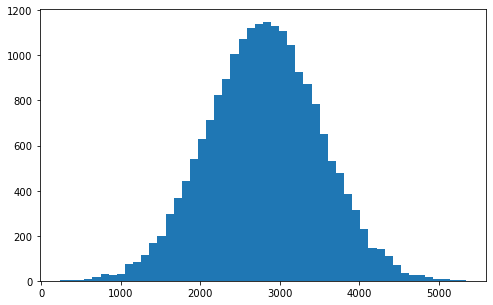

In [592]:
# Plot the sq ft values to confirm their distribution
fig, ax = plt.subplots(figsize=(8, 5))
ax.hist(df['sqft'], bins=50);

## Zip Codes

In [593]:
# Next we'll generate a set of 70 fake zip codes

# Set random seed for reproducability
np.random.seed(5)

zips = np.round(np.random.randn(150),2)
zips = (np.unique(abs(zips)) * 100) + 30000
zips = np.unique(zips)[:70]
np.random.shuffle(zips)

print(zips[:5])
print(f"Unique zip codes: {len(np.unique(zips))}")

[30061. 30043. 30106. 30114. 30089.]
Unique zip codes: 70


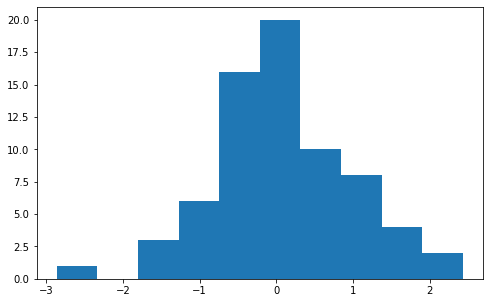

In [594]:
# And assign a random multiplier for price to each zip code.

# Set random seed for reproducability
np.random.seed(5)
zips_x = np.random.randn(70)

# check distribution for zipcode multipliers
fig, ax = plt.subplots(figsize=(8, 5))
ax.hist(zips_x);

In [595]:
# combine zipcodes with their multipliers
zips = np.concatenate((zips.reshape(len(zips), 1), 
                       zips_x.reshape(len(zips_x), 1)), axis=1)

# Sort zips so the first will have the lowest multiplier
zips.sort(axis=0)
zips[:5]

array([[30000.   ,    -2.86 ],
       [30001.   ,    -1.665],
       [30002.   ,    -1.511],
       [30005.   ,    -1.311],
       [30006.   ,    -1.193]])

In [596]:
# Turn array into a dataframe and convert zipcode to string
df_zips = pd.DataFrame(zips, columns=['zip','zip_multi'])

df_zips['zip'] = df_zips['zip'].astype(str, copy=False)
df_zips['zip'] = df_zips['zip'].map(lambda x: x[:5])

df_zips.head()

,zip,zip_multi
0,30000,-2.859688
1,30001,-1.664789
2,30002,-1.511180
3,30005,-1.310773
4,30006,-1.192765


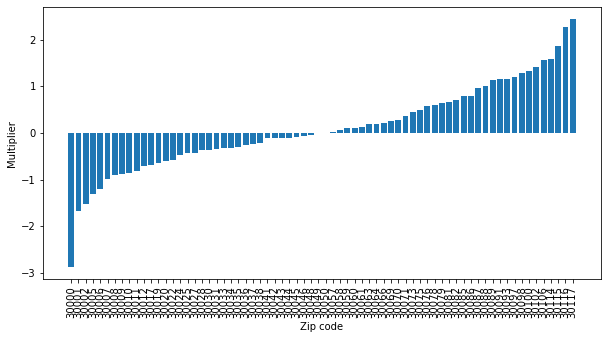

In [597]:
# show distribution of multipliers across zips
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(x=df_zips['zip'], height=df_zips['zip_multi'])
ax.set_xlabel('Zip code')

ax.tick_params(axis='x', which='major', rotation=90)

ax.set_ylabel('Multiplier');

When we naturally drop the first category of zips, it will represent a zip code with a multiplier on the extreme low end, which is not very representative of the population. That's what I want to simulate in this experiment.

I'm going to assign zip codes randomly to groups of houses so zip code will be truly independent of sq ft.

In [598]:
# Assign zip codes and multipliers randomly to houses
df = assign_cats(df_zips, df, seed=5)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sqft       20000 non-null  float64
 1   zip        20000 non-null  object 
 2   zip_multi  20000 non-null  float64
dtypes: float64(2), object(1)
memory usage: 468.9+ KB


## House Condition
This will simulate a rating for the house representing how well it has been maintained, etc. This will be ranked, so houses in below average condition will fetch lower prices, and houses with above average condition will fetch higher prices.

Most houses will receive an average condition, which will have a multiplier of 0.

In [599]:
# Create condition categories and multipliers
conds = [['1_poor', -0.5]
        ,['2_below average', -0.25]
        ,['3_average', 0]
        ,['4_above average', 0.25]
        ,['5_excellent', 0.5]]

df_conds = pd.DataFrame(conds, columns=['condition','condition_multi'])
df_conds.head()

,condition,condition_multi
0,1_poor,-0.50
1,2_below average,-0.25
2,3_average,0.00
3,4_above average,0.25
4,5_excellent,0.50


In [600]:
# create a dictionary to pass with the conditions to make sure the
# average gets applied to the majority of houses
ratio_map = {'1_poor':0.05, '2_below average':0.1, '3_average':0.7,
             '4_above average':0.1, '5_excellent':0.05}

df = assign_cats(df_conds, df, ratio_map, 5)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   sqft             20000 non-null  float64
 1   zip              20000 non-null  object 
 2   zip_multi        20000 non-null  float64
 3   condition        20000 non-null  object 
 4   condition_multi  20000 non-null  float64
dtypes: float64(3), object(2)
memory usage: 781.4+ KB


In [601]:
df['condition'].value_counts()

3_average          14000
2_below average     2000
4_above average     2000
1_poor              1000
5_excellent         1000
Name: condition, dtype: int64

## Confounding variable "Day of the week"
Create a "day of the week" variable representing the day of the week when the buyer viewed the home. 

Intended as a confounding variable that will impact price, but that we can exclude from the model to simulate a more real-world scenario where variability cannot be 100% explained by the data we have available. 

In [602]:
dotw = [['Sunday', 0.05]
       ,['Monday', 0]
       ,['Tuesday', 0.03]
       ,['Wednesday', 0]
       ,['Thursday', 0.025]
       ,['Friday', 0]
       ,['Saturday', 0.02]
       ,['Sunday', 0.01]]

df_dotw = pd.DataFrame(dotw, columns=['dotw','dotw_multi'])
df_dotw.head()

,dotw,dotw_multi
0,Sunday,0.050
1,Monday,0.000
2,Tuesday,0.030
3,Wednesday,0.000
4,Thursday,0.025


In [603]:
# create a dictionary to pass with the conditions to make sure the
# average gets applied to the majority of houses
df = assign_cats(df_dotw, df, seed=5)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   sqft             20000 non-null  float64
 1   zip              20000 non-null  object 
 2   zip_multi        20000 non-null  float64
 3   condition        20000 non-null  object 
 4   condition_multi  20000 non-null  float64
 5   dotw             20000 non-null  object 
 6   dotw_multi       20000 non-null  float64
dtypes: float64(4), object(3)
memory usage: 1.1+ MB


In [604]:
df['dotw'].value_counts()

Sunday       5373
Wednesday    3371
Monday       2975
Tuesday      2674
Saturday     1869
Friday       1869
Thursday     1869
Name: dotw, dtype: int64

## Calculate Price

Price will be calculated based on the variables I've created. 

To keep things simple in this experiment, I'm not going to introduce any multicollinearity, although in real housing data this would likely exist. For instance, average price per square feet might be different in different zip codes, and houses in given zip codes may tend to have more or less square feet than others.

- Baseline (y-intercept) of \\$100,000
- Add \\$100 per sq ft
- Apply multipliers based on zip code, condition, and "day of the week"

In [605]:
# Calculate price based on variables
def calc_homeprice(row, base=100000, sqft_x=100):
    
    # start with base
    price = base
    # add sqft
    price += (row['sqft'] * sqft_x)
    # add zip
    price += (row['zip_multi'] * 10000)
    # add condition
    price += (row['condition_multi'] * price)
    # add dotw
    price += (row['dotw_multi'] * price)
    
    return price
    

In [606]:
df['price'] = df.apply(lambda x : calc_homeprice(x), axis=1)
df.head()

,sqft,zip,zip_multi,condition,condition_multi,dotw,dotw_multi,price
0,3108.859241,30035,-0.305853,3_average,0.0,Saturday,0.02,415983.941748
1,2568.390894,30025,-0.435704,3_average,0.0,Monday,0.00,352482.050177
2,4501.539831,30050,0.003289,3_average,0.0,Monday,0.00,550186.871520
3,2623.535509,30042,-0.105930,1_poor,-0.5,Sunday,0.05,189679.479416
4,2876.726889,30044,-0.100614,3_average,0.0,Saturday,0.02,394399.876356


In [607]:
df.describe()

,sqft,zip_multi,condition_multi,dotw_multi,price
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,2801.130570,0.126523,0.000000,0.017911,387943.368764
std,702.160491,0.952986,0.193654,0.018512,105037.088595
min,232.893150,-2.859688,-0.500000,0.000000,79427.087266
25%,2326.614253,-0.363311,0.000000,0.000000,320718.554017
50%,2803.558121,0.012758,0.000000,0.010000,383663.461980
75%,3278.522942,0.712421,0.000000,0.030000,447858.330478
max,5339.523385,2.430771,0.500000,0.050000,919188.050176


# Explore Data

---------------------------------------------------------------------------
Summary of Data for column: price
---------------------------------------------------------------------------
count     20000.000000
mean     387943.368764
std      105037.088595
min       79427.087266
25%      320718.554017
50%      383663.461980
75%      447858.330478
max      919188.050176
Name: price, dtype: float64


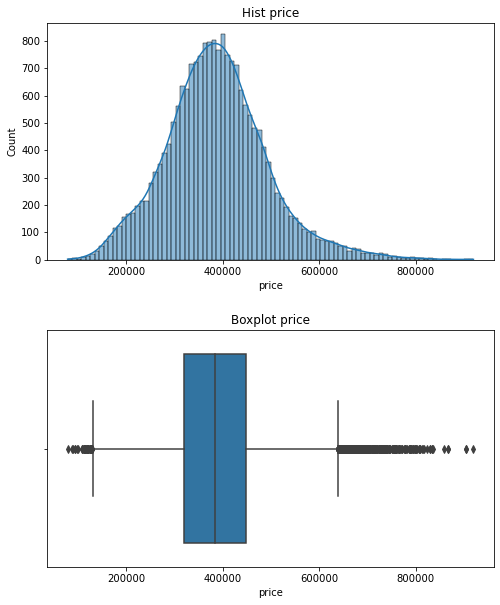


Data is NOT normal with p-statistic = 2.4811788606887796e-208



,col_name,corr_target,assumed_var_type,omnibus_k2,omnibus_pstat,is_normal,uniques,mean,median
0,price,1.0,continuous,956.057931,2.481179e-208,False,NaN,387943.368764,383663.46198


In [608]:
explore_data('price', df, 'price', plot_v_target=False)

---------------------------------------------------------------------------
Summary of Data for column: sqft
---------------------------------------------------------------------------
count    20000.000000
mean      2801.130570
std        702.160491
min        232.893150
25%       2326.614253
50%       2803.558121
75%       3278.522942
max       5339.523385
Name: sqft, dtype: float64


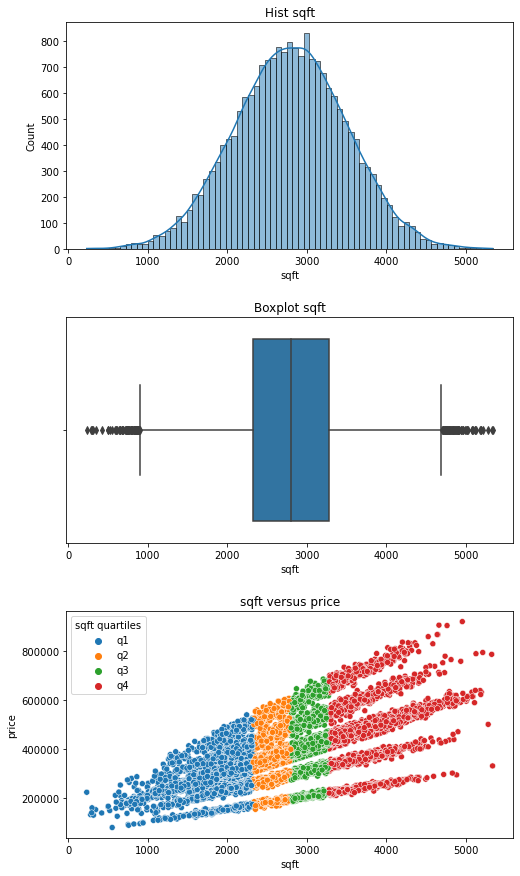


Data IS normal with p-statistic = 0.3749059637869987

---------------------------------------------------------------------------
Summary of Data for column: zip
---------------------------------------------------------------------------
30059    417
30069    410
30081    408
30050    401
30044    399
        ... 
30076    159
30079    157
30006    151
30012    150
30043    148
Name: zip, Length: 70, dtype: int64


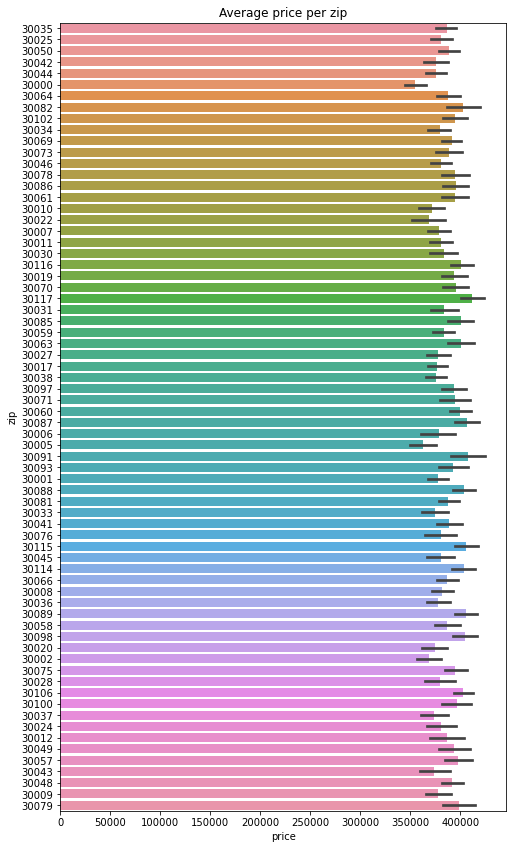

---------------------------------------------------------------------------
Summary of Data for column: condition
---------------------------------------------------------------------------
3_average          14000
2_below average     2000
4_above average     2000
1_poor              1000
5_excellent         1000
Name: condition, dtype: int64


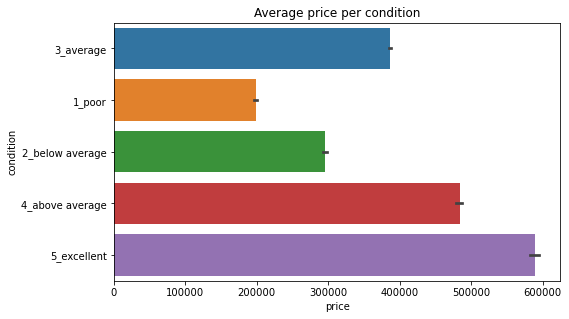

---------------------------------------------------------------------------
Summary of Data for column: dotw
---------------------------------------------------------------------------
Sunday       5373
Wednesday    3371
Monday       2975
Tuesday      2674
Saturday     1869
Friday       1869
Thursday     1869
Name: dotw, dtype: int64


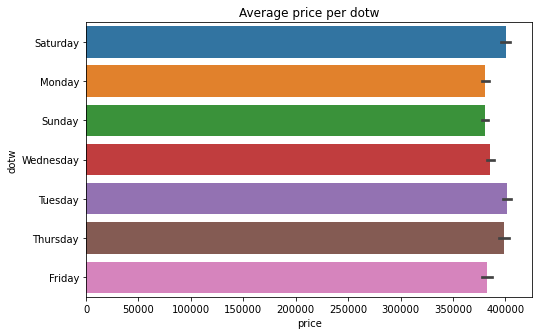

,col_name,corr_target,assumed_var_type,omnibus_k2,omnibus_pstat,is_normal,uniques,mean,median
0,sqft,0.676947,continuous,1.96216,0.374906,True,NaN,2801.13057,2803.558121


In [609]:
ind_vars = ['sqft','zip','condition','dotw']

explore_data(ind_vars, df, 'price')

# Modeling

## Test 1: Drop First, All IVs
In my first iteration, I will include all independent variables, including dotw. I will one-hot-encode zip code and condition, and drop the FIRST category, which is not average.

In [655]:
# One-hot-encode the categorical variables
ohe = OneHotEncoder(drop='first')
ohe_arr = ohe.fit_transform(df[['zip','condition', 'dotw']]).todense()

cols = ohe.get_feature_names(['zip','condition', 'dotw'])
df_ohe = pd.DataFrame(ohe_arr, columns=cols)
df_ohe.head()

,zip_30001,zip_30002,zip_30005,zip_30006,zip_30007,zip_30008,zip_30009,zip_30010,zip_30011,zip_30012,...,condition_2_below average,condition_3_average,condition_4_above average,condition_5_excellent,dotw_Monday,dotw_Saturday,dotw_Sunday,dotw_Thursday,dotw_Tuesday,dotw_Wednesday
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [656]:
# concatenate ohe columns with sqft
df_ohe = pd.concat([df[['sqft']], df_ohe], axis=1)
df_ohe.head()

,sqft,zip_30001,zip_30002,zip_30005,zip_30006,zip_30007,zip_30008,zip_30009,zip_30010,zip_30011,...,condition_2_below average,condition_3_average,condition_4_above average,condition_5_excellent,dotw_Monday,dotw_Saturday,dotw_Sunday,dotw_Thursday,dotw_Tuesday,dotw_Wednesday
0,3108.859241,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,2568.390894,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,4501.539831,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,2623.535509,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,2876.726889,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [657]:
# split dataset into training and testing
x_train, x_test, y_train, y_test = train_test_split(df_ohe, df[['price']], 
                                            test_size=0.25, random_state=5)
print(len(x_train),len(y_train),len(x_test),len(y_test))

15000 15000 5000 5000


In [658]:
# Standardize x_train
scaler = StandardScaler()
scaler.fit_transform(x_train)

df_x_train = pd.DataFrame(x_train)
df_x_train.describe()

,sqft,zip_30001,zip_30002,zip_30005,zip_30006,zip_30007,zip_30008,zip_30009,zip_30010,zip_30011,...,condition_2_below average,condition_3_average,condition_4_above average,condition_5_excellent,dotw_Monday,dotw_Saturday,dotw_Sunday,dotw_Thursday,dotw_Tuesday,dotw_Wednesday
count,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,...,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,2802.708562,0.015867,0.013400,0.010533,0.007333,0.018533,0.017533,0.012733,0.015533,0.017400,...,0.098867,0.701800,0.099067,0.050200,0.149067,0.092667,0.270000,0.094133,0.133000,0.168133
std,701.334292,0.124964,0.114984,0.102093,0.085323,0.134874,0.131252,0.112125,0.123665,0.130761,...,0.298493,0.457483,0.298761,0.218365,0.356166,0.289974,0.443974,0.292024,0.339586,0.373997
min,232.893150,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2329.604688,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2803.382891,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3277.595903,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,5339.523385,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [665]:
# fit linear regression to transformed training data
linreg = LinearRegression(fit_intercept=True)
linreg.fit(df_x_train, y_train)

LinearRegression()

In [669]:
# get r-squared
linreg.score(df_x_train, y_train)

0.9809258251439026

R-Squared is quite high, as expected, since we included the confounding variable and almost all of the variation in this data should be explained.

In [679]:
# get y-intercept
linreg.intercept_

array([-130709.703])

Interesting that this is -130,000 when I believe it should be 100,000.

In [678]:
# get coefficients
coefs = pd.DataFrame(np.array(linreg.coef_).transpose(), index=df_ohe.columns,
                    columns=['coef'])
coefs

,coef
sqft,101.778516
zip_30001,11244.109709
zip_30002,14242.424894
zip_30005,16543.359632
zip_30006,18186.240835
...,...
dotw_Saturday,7450.118317
dotw_Sunday,12995.537319
dotw_Thursday,9160.185884
dotw_Tuesday,11577.313971
